# Fairness in AI: Removing word embeddings

#### Kylian van Geijtenbeek, Thom Visser, Martine Toering, Iulia Ionescu

$\textbf{Abstract:}$ This report attempts to reproduce the word embedding debiasing algorithm and replicate experiments from Bolukbasi, Chang, Zou, Saligrama, and Kalai (2016). We adapt the publicly available implementation (https://github.com/tolga-b/debiaswe) and extend it with the soft debiasing method described in their paper. Several popular benchmarks are integrated in order to evaluate the word embeddings before and after debiasing. Besides replicating results on Word2vec, the effectiveness of the debiasing algorithms is investigated on GloVe and fastText embeddings. We show that the removal of direct bias for all the embeddings barely affects their expressiveness through a comparison of benchmark scores. However, we fail to reproduce large scale soft debiasing results as the method described by the authors is not realistically applicable.

In [1]:
from __future__ import print_function, division
%matplotlib inline
from matplotlib import pyplot as plt
import json
import random
import numpy as np
import copy

import embetter
import embetter.we as we
from embetter.we import WordEmbedding
import embetter.data as data

from embetter.debias import hard_debias
from embetter.benchmarks import Benchmark

from compare_bias import *

# 1 - Gender Bias in Word2vec, Glove and FastText

### Load data

In this notebook, we will use one of the three different word embeddings: $\textbf{Word2vec}$ (Mikolov et al. 2013). $\textbf{GloVe}$ (Pennington et al. 2014) and $\textbf{FastText}$ (Bojanowski et al. 2016) are also available.

The Word2vec embedding we use is learned from a corpus of Google News articles (https://code.google.com/archive/p/word2vec/). The embeddings are 300-dimensional for 3 million words. For GloVe we make use of the 300-dimensional vectors trained on Common Crawl (https://nlp.stanford.edu/projects/glove/). Lastly, FastText is a word embedding from Facebook AI Research lab trained on Wikipedia corpus and Common Crawl and also consists of 300-dimensional vectors (https://fasttext.cc/docs/en/english-vectors.html).

We start by loading in the data.

In [2]:
# Load google news word2vec
E = WordEmbedding("word2vec_small")
# Load soft debiased word2vec (for later)
E_soft = WordEmbedding("word2vec_small_soft_debiased")

Embedding shape: (26423, 300)
26423 words of dimension 300 : in, for, that, is, ..., Jay, Leroy, Brad, Jermaine
Embedding shape: (26423, 300)
26423 words of dimension 300 : in, for, that, is, ..., Jay, Leroy, Brad, Jermaine


All the other embeddings can be loaded in a similar fashion, using the embedding names in the table on the GitHub Repository *(word2vec_small_hard_debiased, glove_small, glove_small_hard_debiased, glove_small_soft_debiased, word2vec_large, fasttext_small, fasttext_small_hard_debiased, fasttext_small_soft_debiased, glove_large, fasttext_large, or custom embedding file)*.

## Word2vec

In [3]:
# Load professions and gender related lists from Bolukbasi et al. for Word2vec

gender_seed, defs, equalize_pairs, profession_words = data.load_data(E.words)

### Define gender direction

We define the gender direction by either PCA or by the words "she" and "he" for Word2vec. \
The PCA method is generally more robust by incorporating all definitional word pairs.

In [4]:
# Define gender direction with the words "she" and "he" 
# v_gender = E.diff('she', 'he')

# Define gender direction with PCA
v_gender = we.doPCA(defs, E).components_[0]

### Generating analogies


Below, we show some of the gender analogies that we can create from the embeddings. \
This method is based on "she is to X as he is to Y" analogies, with X looping through all the words and then finding the appropriate Y. \
"she" and "he" are either the embeddings of these words, or the extremes of the first principal component, depending on the method used above.

In [5]:
# Analogies gender
a_gender = E.best_analogies_dist_thresh(v_gender, thresh=1)
we.viz(a_gender)

Computing neighbors...
Mean number of neighbors per word: 10.219732808538016
Median of number of neighbors per word: 7.0
Index                          Analogy                   Gender score
---------------------------------------------------------------------
   0                      herself | himself                      0.94
   1                          she | he                           0.94
   2                          her | his                          0.91
   3                        woman | man                          0.82
   4                     daughter | son                          0.74
   5                         girl | boy                          0.74
   6                      actress | actor                        0.72
   7                businesswoman | businessman                  0.70
   8                       sister | brother                      0.69
   9                       mother | father                       0.69
  10                  spokeswoman | spo

These analogies offer an insight in potential biases along the specified bias axis (in this case gender). This is useful for a qualitative analysis.

### Analyzing occupational gender bias 


The projection of occupations on the bias axis serves as another useful source for qualitative analysis.

In [6]:
# Analysis of extreme male and extreme female professions
sp = E.profession_stereotypes(profession_words, v_gender)

                Female                |                 Male                 
-----------------------------------------------------------------------------
0.38                    businesswoman | maestro                        -0.244
0.379                         actress | protege                        -0.236
0.378                       housewife | statesman                      -0.222
0.323                       homemaker | businessman                    -0.219
0.308                           nurse | sportsman                      -0.209
0.302                registered_nurse | philosopher                    -0.196
0.297                        waitress | marksman                       -0.192
0.28                     receptionist | skipper                        -0.187
0.278                       socialite | financier                      -0.183
0.277                       librarian | architect                      -0.177
0.272                            maid | magician                

# 2 - Comparing Bias of Word2vec and FastText

We will compare the gender bias between word embeddings Word2vec and FastText. We do this by following Bolukbasi et al.'s approach shown in Figure 4 in their paper. The profession words are projected onto the gender axis for two embeddings. Each datapoint represents a profession word.

Below we compare the bias of Word2vec and FastText.

Embedding shape: (27014, 300)
27014 words of dimension 300 : the, and, of, to, ..., circumscribed, whos, salvaging, anion


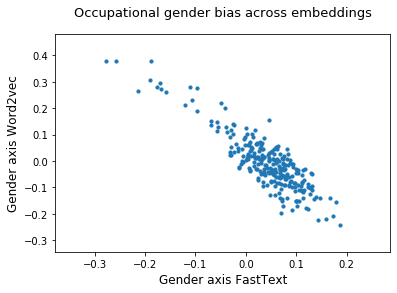

In [7]:
E_f = WordEmbedding("fasttext_small")
compare_occupational_bias(E, E_f, ["Word2vec", "FastText"])

# 3 - Debiasing algorithms on Word2vec

## Hard debiasing

In hard debiasing, the gender neutral words are shifted to zero in the gender subspace (i.e. neutralized) by subtracting the projection of the neutral word embedding vector onto the gender subspace and renormalizing the resulting embedding to unit length. 

## Soft debiasing

Soft debiasing is done by solving the following optimization problem as mentioned in their paper:

\begin{equation}
    \underset{T}{\min} || (TW)^T(TW) - W^TW||^2_F + \lambda ||(TN)^T (TB)||^2_F
\end{equation}

where W is the matrix of all embedding vectors, N is the matrix of the embedding vectors of the gender neutral words, B is the gender subspace, and T is the debiasing transformation that minimizes the projection of the neutral words onto the gender subspace but tries to maintain the pairwise inner products between the words.

For the optimization, we adapted specifics from Manzini, Chong, Black, and Tsvetkov (2019), where our code is based on the code they provide (https://github.com/TManzini/DebiasMulticlassWordEmbedding).

### Hard debiasing Word2vec
Firstly, we show how to manually debias embeddings of choice. \
This overwrites the embeddings in the WordEmbedding object, so make sure to re-load the biased embeddings in a new WordEmbedding object for comparison between the benchmarks (as is done in this notebook in the Benchmarks section).

In [8]:
# Pass the WordEmbedding object which contains the embeddings that should be debiased.
hard_debias(E, gender_seed, defs, equalize_pairs)

Secondly, we show the effect of hard debiasing on Word2vec.

In [9]:
# Hard debiased Word2vec
# Analysis of extreme male and extreme female professions
sp_hard_debiased = E.profession_stereotypes(profession_words, v_gender)

                Female                |                 Male                 
-----------------------------------------------------------------------------
0.433                   businesswoman | businessman                    -0.433
0.379                         actress | congressman                    -0.428
0.378                       housewife | dad                            -0.365
0.297                        waitress | councilman                     -0.358
0.272                            maid | statesman                      -0.222
0.265                             nun | salesman                       -0.157
0.261                       ballerina | handyman                       -0.107
0.0                  registered_nurse | monk                           -0.082
0.0                       soft_spoken | nanny                            -0.0
0.0                        evangelist | stylist                          -0.0
0.0                         patrolman | financier               

In [10]:
# Analogies gender
a_gender_hard_debiased = E.best_analogies_dist_thresh(v_gender)
we.viz(a_gender_hard_debiased)

Computing neighbors...
Mean number of neighbors per word: 10.218597434053665
Median of number of neighbors per word: 7.0
Index                          Analogy                   Gender score
---------------------------------------------------------------------
   0                congresswoman | congressman                  1.00
   1                         aunt | uncle                        1.00
   2                        filly | colt                         1.00
   3                granddaughter | grandson                     1.00
   4                    daughters | sons                         1.00
   5                      herself | himself                      1.00
   6                          she | he                           1.0
   7                      females | males                        1.0
   8                  spokeswoman | spokesman                    1.0
   9                     sorority | fraternity                   1.0
  10                 ex_boyfriend | ex_girl

# 4 - Benchmarks

This package includes some basic benchmarks, which allow for easy verification of the embedding's quality before and after debiassing (RG-65, WS-353 and MSR), as well as a statistical measure of bias to quantitatively inspect the effect of debiassing (WEAT).

In [11]:
benchmark = Benchmark()
E_before = WordEmbedding("word2vec_small")

Embedding shape: (26423, 300)
26423 words of dimension 300 : in, for, that, is, ..., Jay, Leroy, Brad, Jermaine


### Word2vec

Below, we show the benchmarks for Word2vec. \
When comparing the WEAT effect size, make sure to use a single Benchmark object per embedding, benchmarking the biased version first, as is done in this notebook. (This is because the first bias axis is saved internally to measure bias along it for subsequent embeddings.)

In [12]:
# Evaluate for Word2vec
before_results = benchmark.evaluate(E_before, "Before")
hard_results = benchmark.evaluate(E, "Hard")
soft_results = benchmark.evaluate(E_soft, "Soft")


100%|██████████| 40/40 [00:05<00:00,  5.63it/s]


+-------------------------------------------------------+
|                   Results for Before                  |
+---------------+-------+-----------+-------------------+
| Dataset       | Found | Not Found |       Score       |
+---------------+-------+-----------+-------------------+
| EN-RG-65      |   53  |     12    | 77.66555804950227 |
| EN-WS-353-ALL |  318  |     35    | 68.82719646959825 |
| MSR-analogy   |  5276 |    2724   | 46.79681576952237 |
| WEAT          |   -   |     -     |     1.4925852     |
+---------------+-------+-----------+-------------------+


100%|██████████| 40/40 [00:05<00:00,  8.05it/s]


+--------------------------------------------------------+
|                    Results for Hard                    |
+---------------+-------+-----------+--------------------+
| Dataset       | Found | Not Found |       Score        |
+---------------+-------+-----------+--------------------+
| EN-RG-65      |   53  |     12    | 77.49622028082247  |
| EN-WS-353-ALL |  318  |     35    | 68.52623098234018  |
| MSR-analogy   |  5276 |    2724   | 46.967399545109934 |
| WEAT          |   -   |     -     |     0.39473134     |
+---------------+-------+-----------+--------------------+


100%|██████████| 40/40 [00:05<00:00,  8.03it/s]


+-------------------------------------------------------+
|                    Results for Soft                   |
+---------------+-------+-----------+-------------------+
| Dataset       | Found | Not Found |       Score       |
+---------------+-------+-----------+-------------------+
| EN-RG-65      |   53  |     12    | 77.66555804950227 |
| EN-WS-353-ALL |  318  |     35    | 68.82719646959825 |
| MSR-analogy   |  5276 |    2724   | 46.79681576952237 |
| WEAT          |   -   |     -     |    -0.22441924    |
+---------------+-------+-----------+-------------------+


The results of individual benchmarks can be combined into a single list and passed to benchmark's `pprint_compare` method for easy comparison.

In [14]:
w2v_results = [before_results, hard_results, soft_results]
benchmark.pprint_compare(w2v_results, ["Before", "Hard-debiased", "Soft-debiased"], "word2vec")

+------------------------------------------------------------------------------------------+
|                                   Results for word2vec                                   |
+---------------+-------------------+-------------------+--------------------+-------------+
|     Score     |       RG-65       |       WS-35       |        MSR         |     WEAT    |
+---------------+-------------------+-------------------+--------------------+-------------+
|     Before    | 68.82719646959825 | 77.66555804950227 | 46.79681576952237  |  1.4925852  |
| Hard-debiased | 68.52623098234018 | 77.49622028082247 | 46.967399545109934 |  0.39473134 |
| Soft-debiased | 68.82719646959825 | 77.66555804950227 | 46.79681576952237  | -0.22441924 |
+---------------+-------------------+-------------------+--------------------+-------------+


# 5 - Full Experiments

The full range of experiments can be executed using the `experiments.py` file from the repository. \
This is best done through a terminal, to modify the behaviour using command line arguments, but its also available here. \
Gender analogies and occupational gender bias are shown for *word2vec_small*, *glove_small*, and *fasttext_small* before debiasing, after hard-debiasing and after soft-debiasing.

In [15]:
!python experiments.py

################## EXPERIMENT DETAILS ##################
#                                                      #
# Analogies and occupations: True                      #
# Do soft debiasing from scratch: False                #
# Perform benchmarks: True                             #
#                                                      #
# Performing experiments for the following embeddings: #
#	- word2vec_small                               #
#	- glove_small                                  #
#	- fasttext_small                               #
#                                                      #
########################################################

########################################################
#           Doing the word2vec_small embedding         #
########################################################
Embedding shape: (26423, 300)
26423 words of dimension 300 : in, for, that, is, ..., Jay, Leroy, Brad, Jermaine
Computing neighbors...
Mean number of neighbors pe

                Female                |                 Male                 
-----------------------------------------------------------------------------
0.433                   businesswoman | businessman                    -0.433
0.379                         actress | congressman                    -0.428
0.378                       housewife | dad                            -0.365
0.297                        waitress | councilman                     -0.358
0.272                            maid | statesman                      -0.222
0.265                             nun | salesman                       -0.157
0.261                       ballerina | handyman                       -0.107
0.0                  registered_nurse | monk                           -0.082
0.0                       soft_spoken | nanny                            -0.0
0.0                        evangelist | stylist                          -0.0
0.0                         patrolman | financier               